# **MÁSTER EN FORMACIÓN PERMANENTE EN INTELIGENCIA ARTIFICIAL** 
##                      TRABAJO FIN DE MÁSTER 
### Modelo de IA para mantenimiento predictivo de activo crítico en la producción de oxígeno para diferentes industrias 
#####                Hernan Camilo Gonzalez Rodriguez

## Índice
- [Importación de Librerias](#importacion-de-librerias)
- [Carga de datos](#carga-de-datos)
- [Análisis exploratorio de datos](#analisis-exploratorio-de-datos)
- [Preparación de datos](#preparacion-de-datos)
- [Modelo de predicción LSTM](#modelo-de-prediccion)
- [Código métricas para evaluación del modelo](#metricas-de-evaluacion-de-modelo)
- [Código para generar gráficas de resultados](#graficas-de-resultados)
- [Entrenamiento del modelo](#entrenamiento-del-modelo)


# Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import random
import os
warnings.filterwarnings('ignore')

c:\Users\herna\.conda\envs\maestria\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Configuración de la semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

# Carga de datos

In [3]:
# Cargar datos y establecer la columna fecha como indice
df = pd.read_csv("dataset.csv", parse_dates=['Date'] , index_col='Date')
df = df.sort_index()
df_test = pd.read_csv("dataset_test.csv", parse_dates=['Date'] , index_col='Date')
df_test = df_test.sort_index()

# Analisis exploratorio de datos

In [4]:
# Visualización del dataset
df.head()

,Temperature,Vibration,Pressure,Current,Humidity,Caudal,Unhealthy
Date,,,,,,,
2024-03-05 00:00:00,66.584691,31.131352,100047.384427,10.364606,-49.759341,4353.793981,0
2024-03-05 00:15:00,59.990772,30.474256,100070.822254,9.815225,-49.401541,4181.549393,0
2024-03-05 00:30:00,67.997727,31.640593,100014.914669,10.550456,-51.860662,4371.914569,0
2024-03-05 00:45:00,58.250629,30.876819,100009.545733,9.923341,-44.369077,4107.992494,1
2024-03-05 01:00:00,57.924326,30.545140,100004.641705,9.935305,-50.732154,4120.612575,0


In [5]:
# Obtener la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8640 entries, 2024-03-05 00:00:00 to 2024-06-02 23:45:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  8640 non-null   float64
 1   Vibration    8640 non-null   float64
 2   Pressure     8640 non-null   float64
 3   Current      8640 non-null   float64
 4   Humidity     8640 non-null   float64
 5   Caudal       8640 non-null   float64
 6   Unhealthy    8640 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 540.0 KB


In [6]:
# Validacion de existencia de  nulos 
print("Nulos en el dataset:", df.isnull().sum().sum())
# Validacion si hay valores nulos o faltantes
df.isna().any()

Nulos en el dataset: 0


Temperature    False
Vibration      False
Pressure       False
Current        False
Humidity       False
Caudal         False
Unhealthy      False
dtype: bool

In [7]:
# Obtención datos estadisticos del dataset
df.describe()

,Temperature,Vibration,Pressure,Current,Humidity,Caudal,Unhealthy
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,64.856665,33.143522,100116.452547,10.546142,-50.294759,4185.968737,0.119213
std,6.881706,3.542809,105.460533,0.825460,1.263065,162.026282,0.324058
min,51.063491,29.068336,99830.860844,7.035076,-57.358331,3700.093215,0.000000
25%,59.794466,31.047538,100041.073350,10.159091,-51.091725,4087.141159,0.000000
50%,64.384705,32.211812,100098.753721,10.398506,-50.329070,4200.449788,0.000000
75%,68.840290,34.087808,100174.043709,10.725596,-49.557654,4295.253710,0.000000
max,110.555087,52.969233,100544.221551,16.998881,-44.002820,5448.289724,1.000000


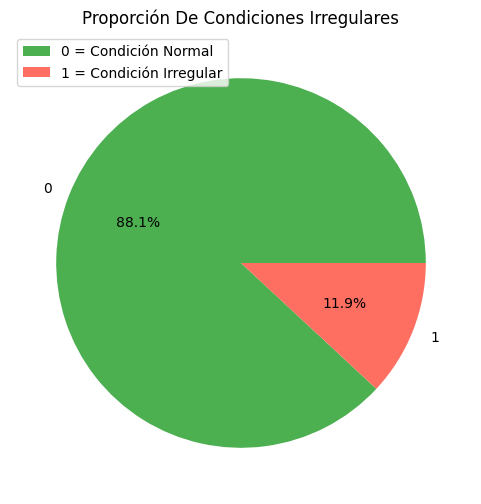

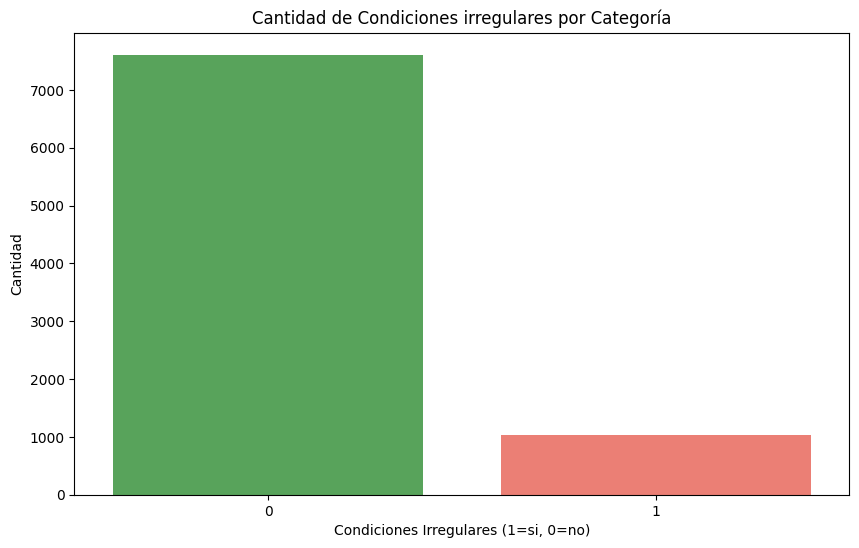

Cantidad de condiciones irregulares por categoria:
 Unhealthy
0    7610
1    1030
Name: count, dtype: int64


In [8]:
# Validar y gráficar desbalance de  "cOndiciones irregulares"
unhealthy_counts = df['Unhealthy'].value_counts()

# Colores personalizados para el gráfico
colores = ['#4CAF50', '#FF6F61']  # Verde, Rojo claro

#  Gráfico de Pastel
plt.figure(figsize=(6, 6))
plt.pie(unhealthy_counts, labels=unhealthy_counts.index, autopct='%1.1f%%', colors=colores)
plt.title("Proporción De Condiciones Irregulares")
plt.legend(['0 = Condición Normal', '1 = Condición Irregular'], loc='best')
plt.show()

# Gráfico de barras para ver la cantidad de fallos
plt.figure(figsize=(10, 6))
sns.countplot(x='Unhealthy', data=df, palette=colores)
plt.title('Cantidad de Condiciones irregulares por Categoría')
plt.xlabel('Condiciones Irregulares (1=si, 0=no)')
plt.ylabel('Cantidad')
plt.show()

print("Cantidad de condiciones irregulares por categoria:\n", unhealthy_counts)

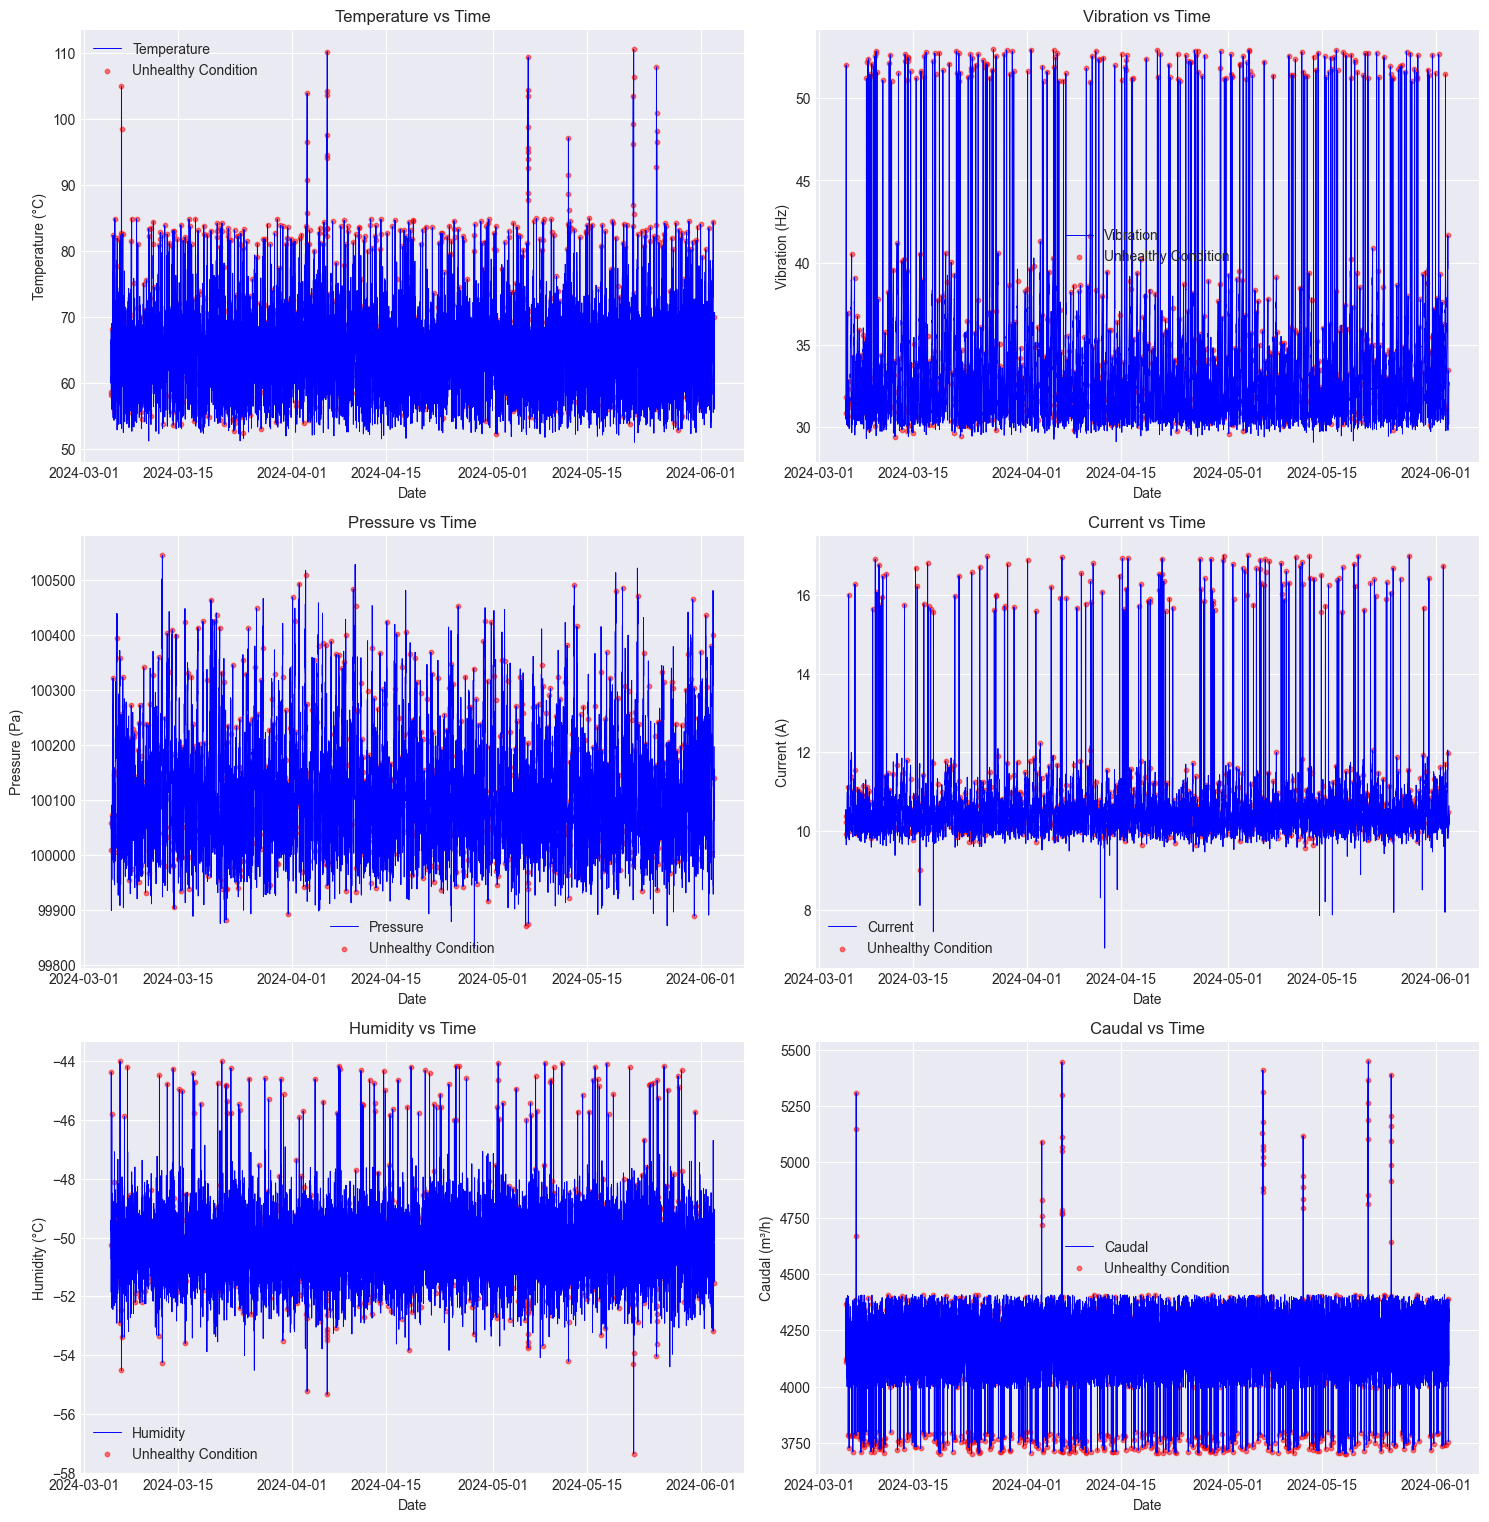

In [9]:
# Visualización de las variables
plt.style.use("seaborn-v0_8-darkgrid")
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()

# Lista de variables y sus unidades para graficar
variables = [
    ("Temperature", "°C"),
    ("Vibration", "Hz"),
    ("Pressure", "Pa"),
    ("Current", "A"),
    ("Humidity", "°C"),
    ("Caudal", "m³/h")
]

for i, (var, unidad) in enumerate(variables):
    axs[i].plot(df.index, df[var], label=var, color="blue", linewidth=0.7)
    # Resaltar los puntos donde se registró una condicion anormal
    cA_df = df[df["Unhealthy"] == 1]
    axs[i].scatter(cA_df.index, cA_df[var], color="red", s=10, label="Unhealthy Condition", alpha=0.5)
    axs[i].set_title(f"{var} vs Time")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel(f"{var} ({unidad})")
    axs[i].legend()

# Eliminar subplots vacíos si existen
for j in range(len(variables), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

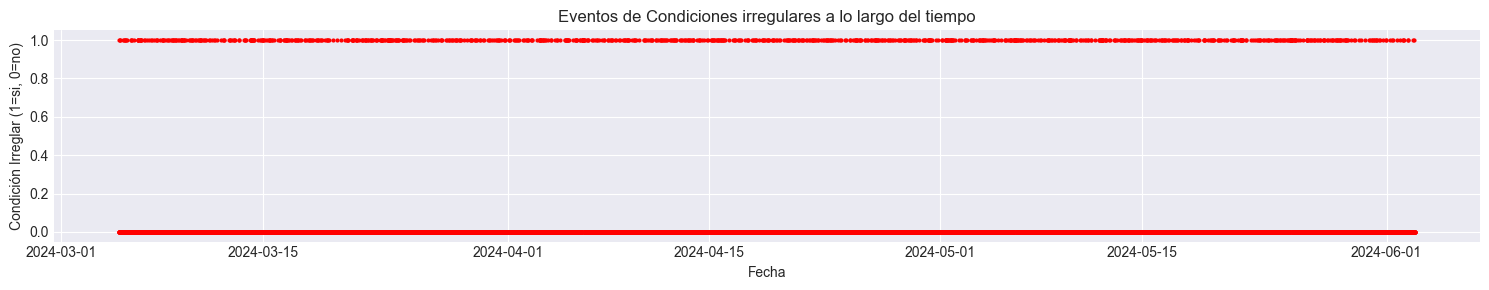

In [10]:
# Gráfica adicional de eventos "Unhealthy" en el tiempo
plt.figure(figsize=(15, 3))
plt.plot(df.index, df["Unhealthy"], color="red", linestyle="None", marker="o", markersize=2)
plt.title("Eventos de Condiciones irregulares a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Condición Irreglar (1=si, 0=no)")
plt.tight_layout()
plt.show()

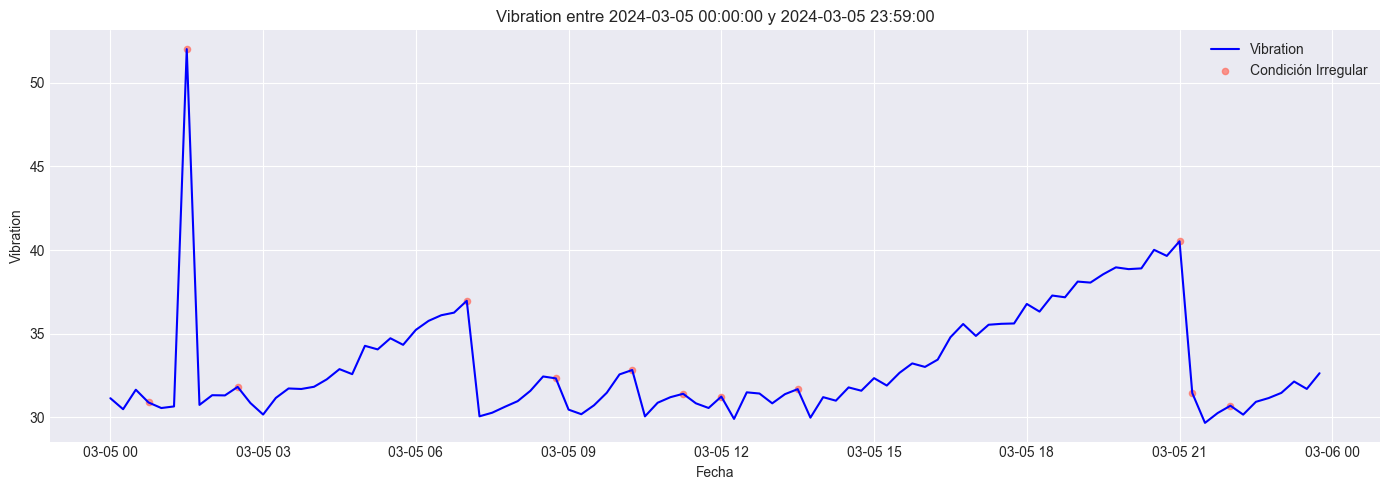

In [11]:
# Funcion para graficar la variable seleccionada en el rango de fechas indicado
def graficar_variable(df, variable, fecha_inicio, fecha_fin):
    """
    Grafica la variable seleccionada en el rango de fechas indicado.
    
    Args:
        df: DataFrame con índice de fechas.
        variable: Nombre de la columna a graficar (str).
        fecha_inicio: Fecha de inicio (str o pd.Timestamp).
        fecha_fin: Fecha de fin (str o pd.Timestamp).
    """
    # Filtrar por rango de fechas
    df_filtrado = df.loc[fecha_inicio:fecha_fin]
    plt.figure(figsize=(14, 5))
    plt.plot(df_filtrado.index, df_filtrado[variable], color='blue', label=variable)
    # Resaltar condiciones irregulares si existen
    if 'Unhealthy' in df_filtrado.columns:
        cA_df = df_filtrado[df_filtrado["Unhealthy"] == 1]
        plt.scatter(cA_df.index, cA_df[variable], color="#FF6F61", s=20, label="Condición Irregular", alpha=0.7)
    plt.title(f"{variable} entre {fecha_inicio} y {fecha_fin}")
    plt.xlabel("Fecha")
    plt.ylabel(variable)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# LLamado a la funcion 
graficar_variable(df, "Vibration", "2024-03-05 00:00:00", "2024-03-05 23:59:00")

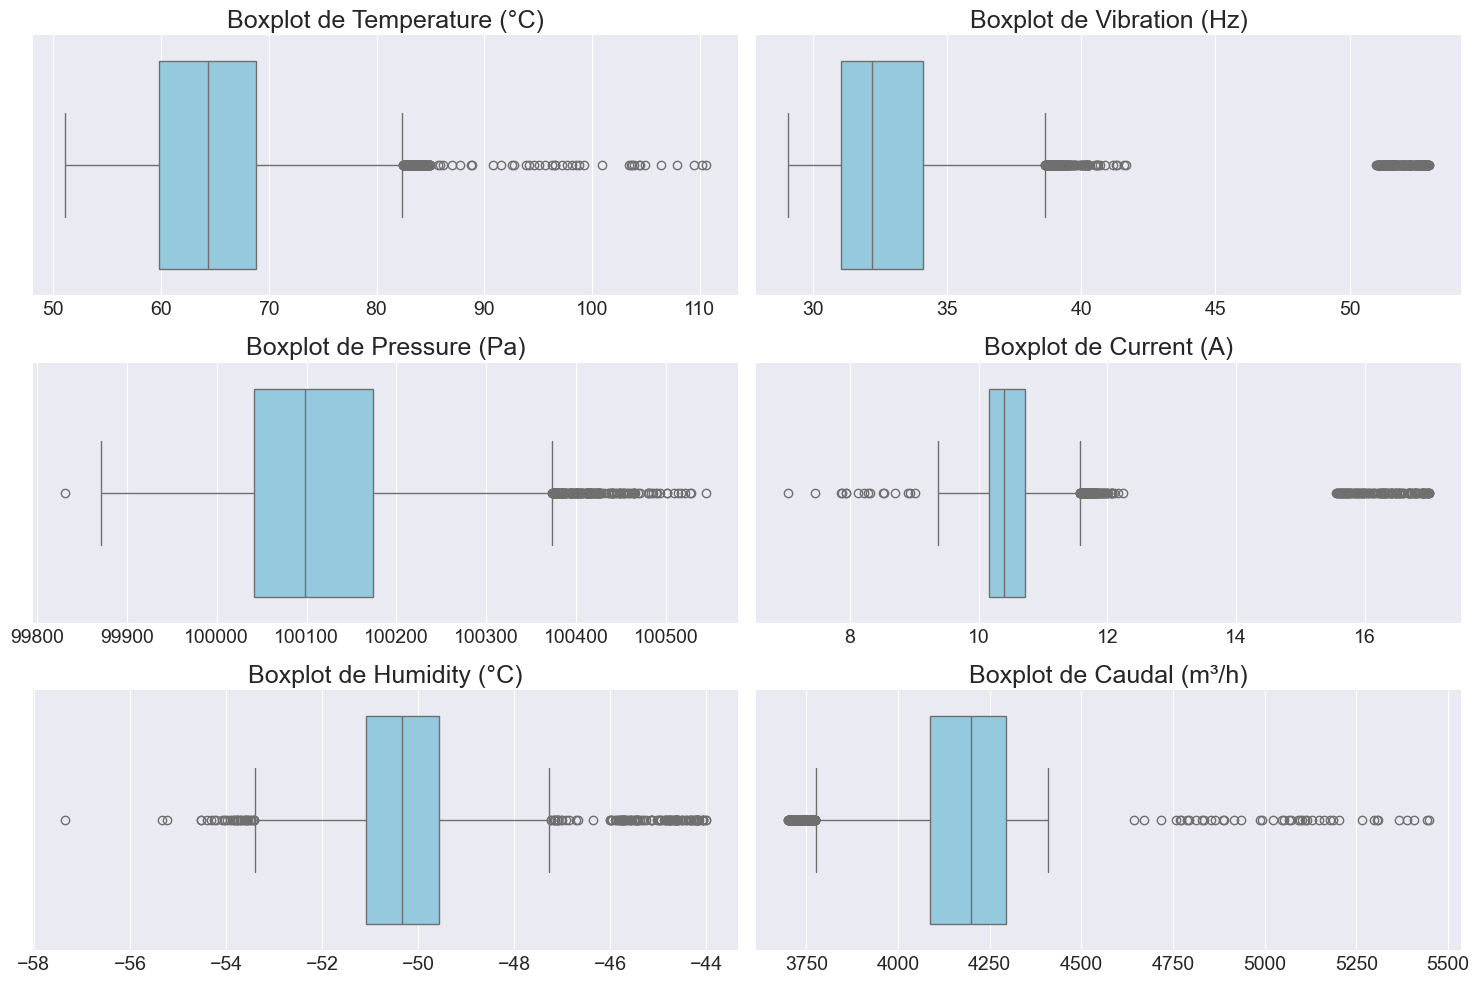

In [12]:
# Revisión de outliers con boxplots
variables = [
    ("Temperature", "°C"),
    ("Vibration", "Hz"),
    ("Pressure", "Pa"),
    ("Current", "A"),
    ("Humidity", "°C"),
    ("Caudal", "m³/h")
]

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15, 10))
for i, (col, unidad) in enumerate(variables):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot de {col} ({unidad})", fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

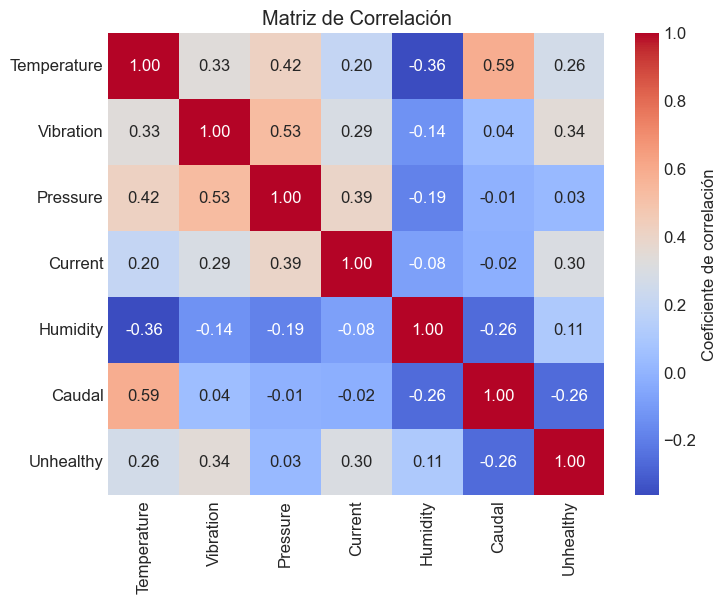

In [13]:
# Grafico de correlacion
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Coeficiente de correlación'})
plt.title("Matriz de Correlación")
plt.show()

In [14]:
# Segregacion de los sensores
sensor_columns = [col for col in df.columns if col != "Unhealthy"]


===== Descomposición STL para: Temperature =====


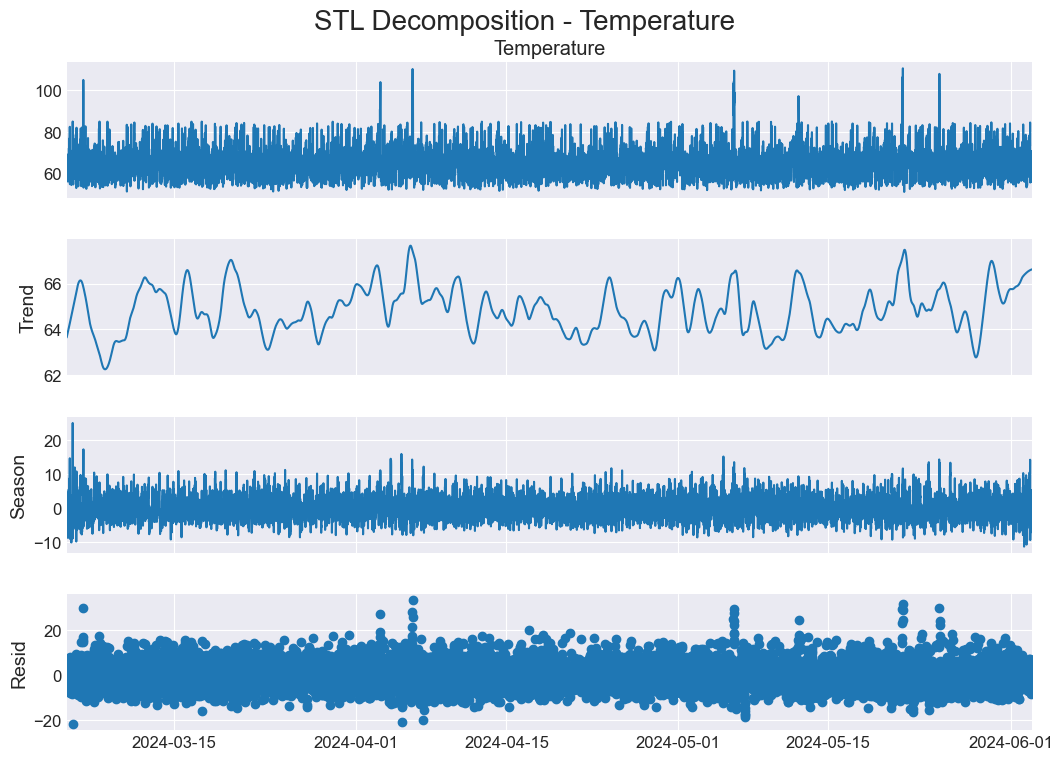


===== Descomposición STL para: Vibration =====


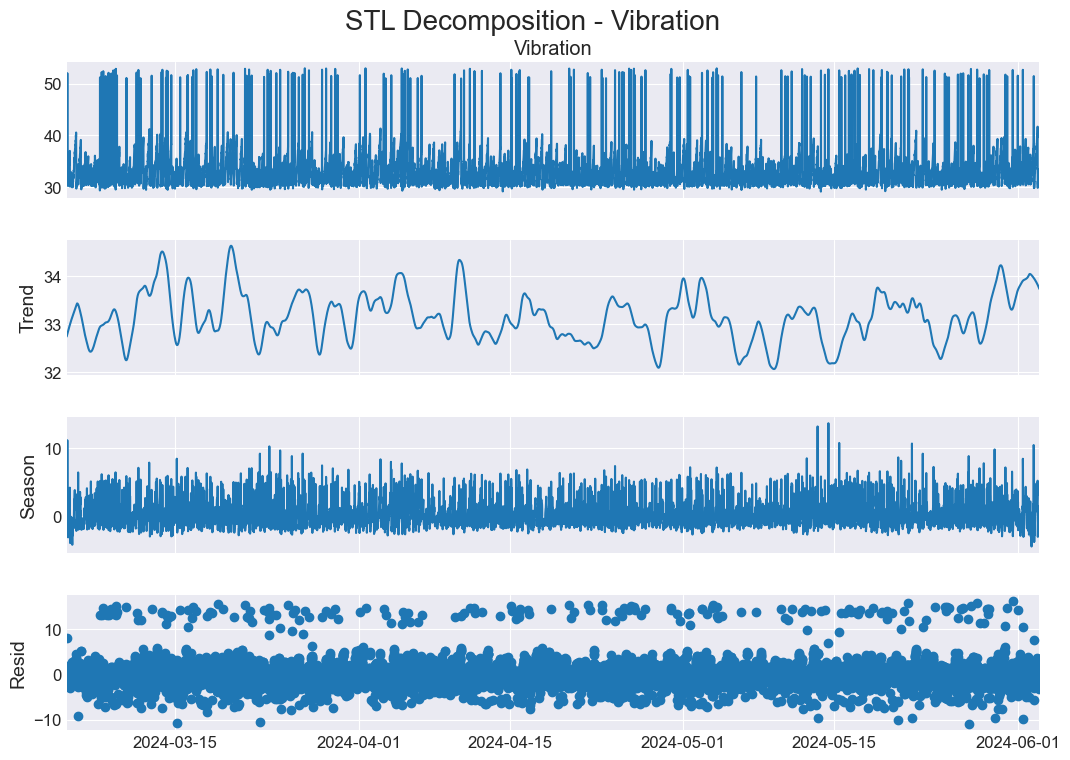


===== Descomposición STL para: Pressure =====


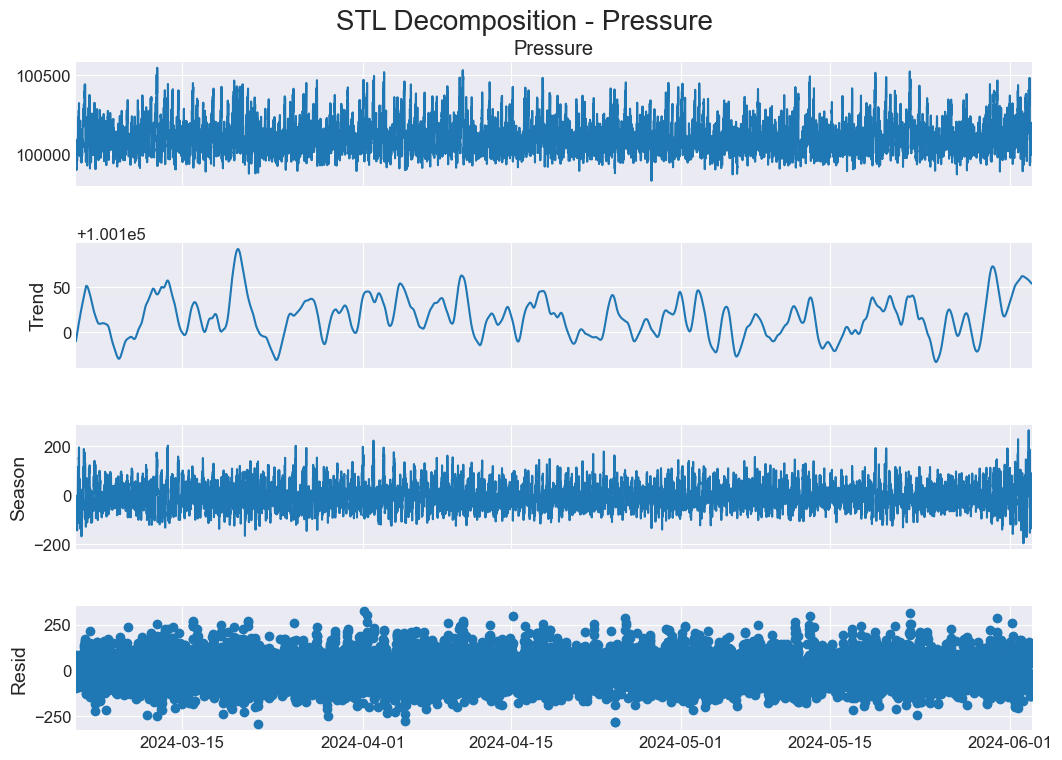


===== Descomposición STL para: Current =====


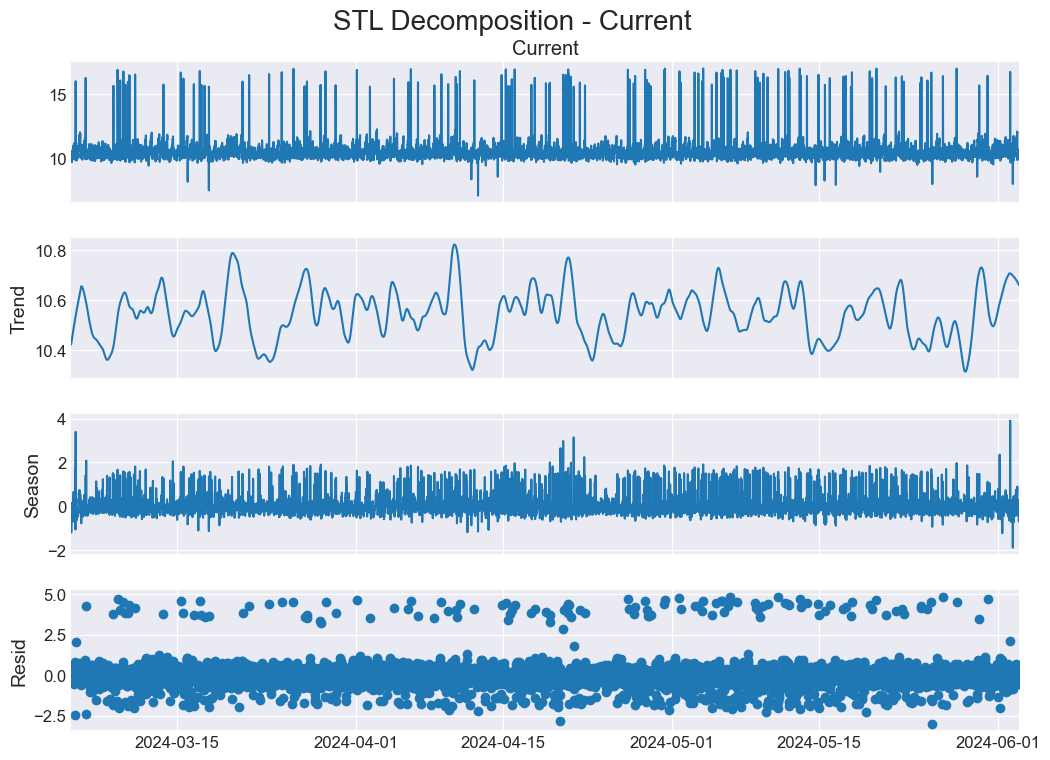


===== Descomposición STL para: Humidity =====


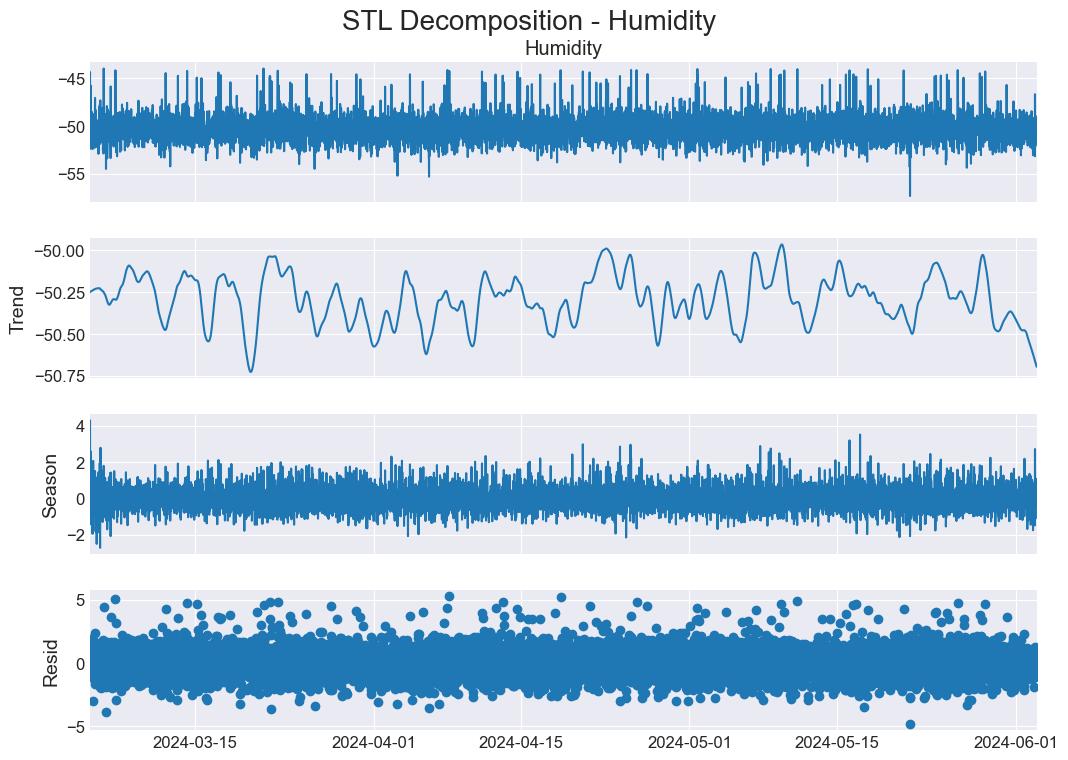


===== Descomposición STL para: Caudal =====


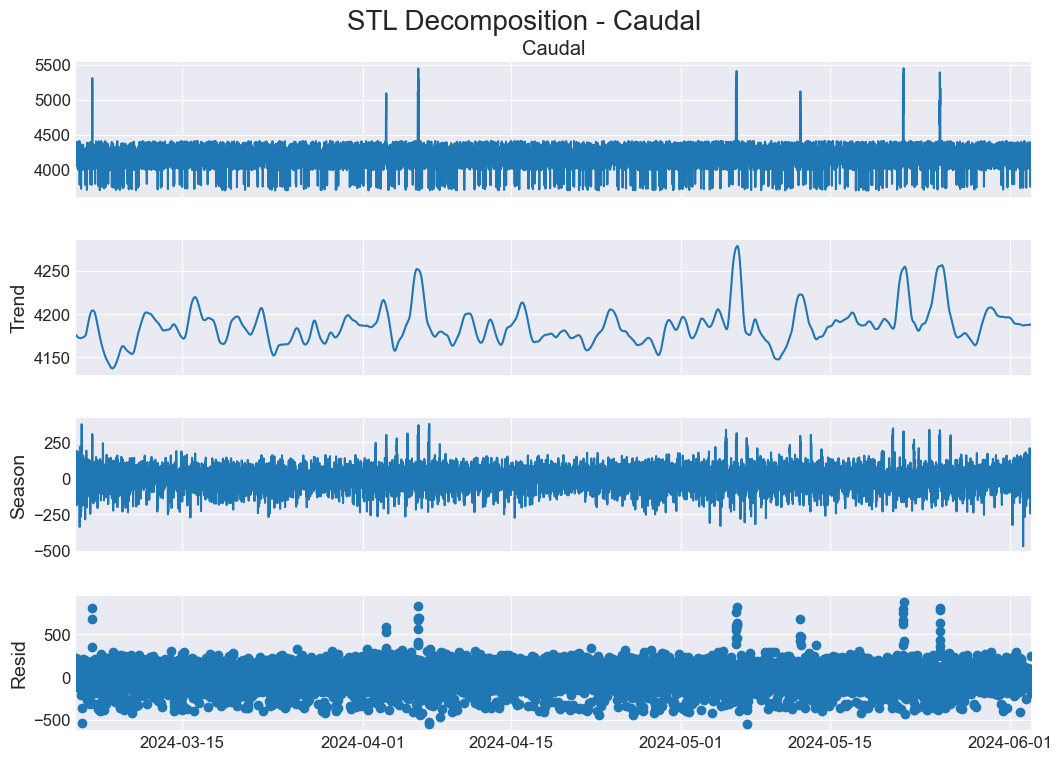

In [15]:
# Descomposición STL

plt.rcParams.update({'font.size': 12})
for sensor in sensor_columns:
    print(f"\n===== Descomposición STL para: {sensor} =====")
    serie = df[sensor].dropna()

    stl = STL(serie, period=96)  # 96 intervalos de 30 minutos (24×4).
    result = stl.fit()

    fig = result.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"STL Decomposition - {sensor}", fontsize=20)

    # Aumentar tamaño de fuente en cada subplot
    for ax in fig.axes:
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        ax.tick_params(axis='both', labelsize=12)

    plt.show()

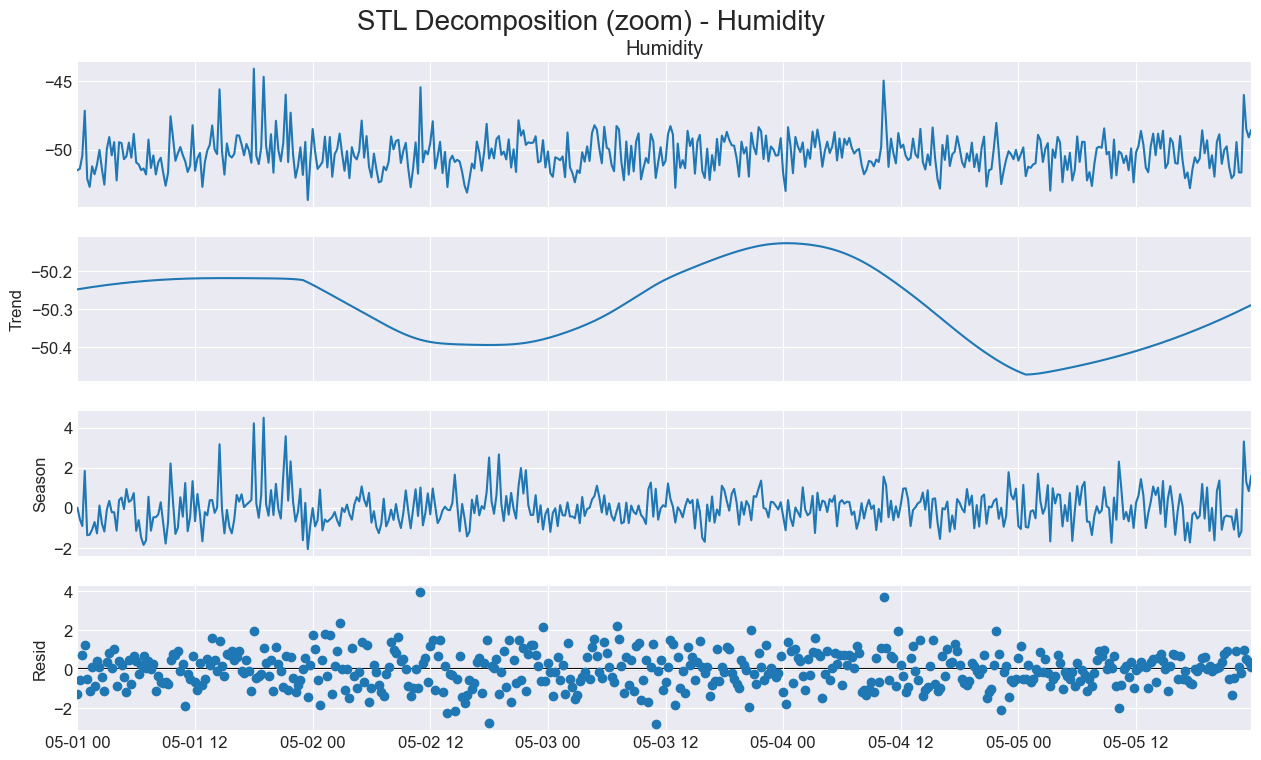

In [16]:
# Función para hacer zoom en la descomposición de un sensor
def plot_stl_zoom(sensor_name, start_date=None, end_date=None):
    if sensor_name not in sensor_columns:
        print(f"Sensor '{sensor_name}' no encontrado.")
        return
    
    serie = df[sensor_name].dropna()
    if not pd.api.types.is_datetime64_any_dtype(serie.index):
        serie.index = pd.date_range(start='2024-03-15', periods=len(serie), freq='15min')
    
    if start_date and end_date:
        serie = serie.loc[start_date:end_date]
    
    stl = STL(serie, period=96)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 8)
    fig.suptitle(f"STL Decomposition (zoom) - {sensor_name}", fontsize=20)
    plt.show()

# Llamado a la función con rango de fechas
plot_stl_zoom('Humidity', start_date='2024-05-01', end_date='2024-05-05')

<Figure size 1500x500 with 0 Axes>

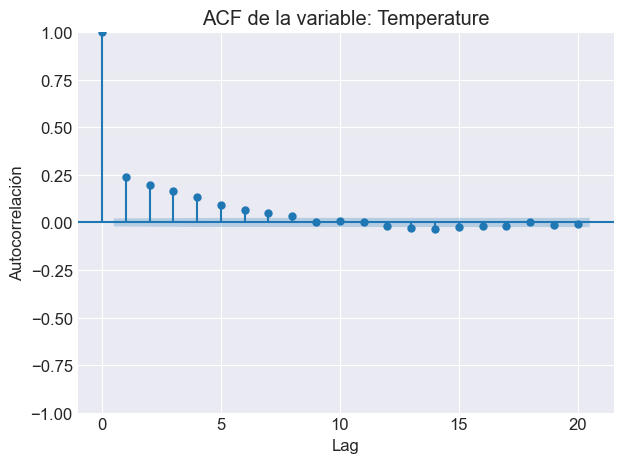

<Figure size 1500x500 with 0 Axes>

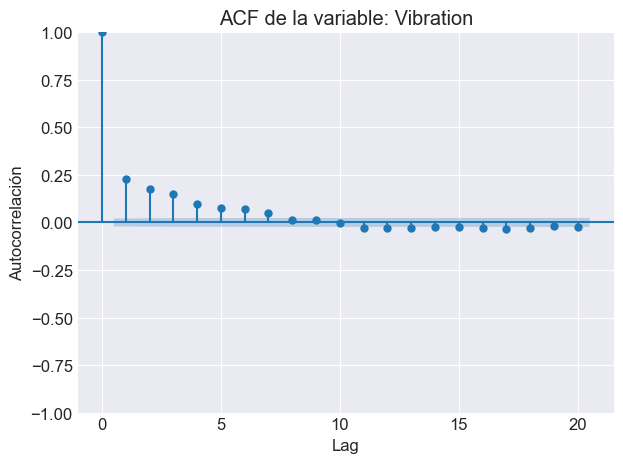

<Figure size 1500x500 with 0 Axes>

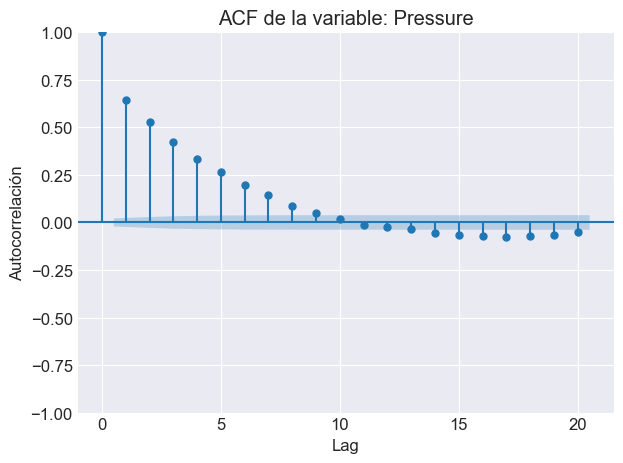

<Figure size 1500x500 with 0 Axes>

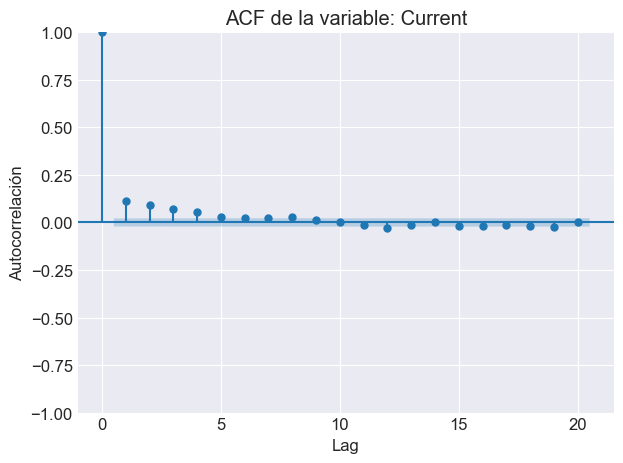

<Figure size 1500x500 with 0 Axes>

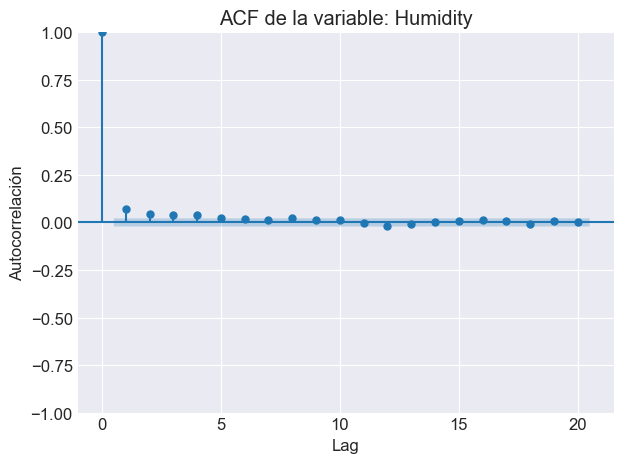

<Figure size 1500x500 with 0 Axes>

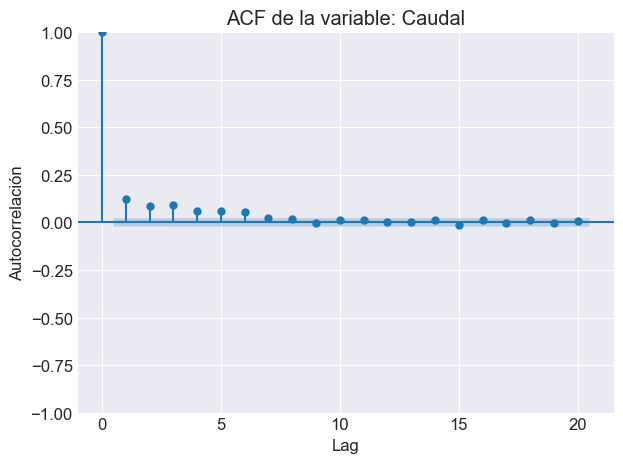

In [17]:
# Gráfica de ACF para cada sensor
for sensor in sensor_columns:
    plt.figure(figsize=(15, 5))
    plot_acf(df[sensor].dropna(), lags=20, alpha=0.05)
    plt.title(f"ACF de la variable: {sensor}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelación")
    plt.tight_layout()
    plt.show()

In [18]:
# Prueba de Dickey-Fuller aumentada para cada sensor y determinacion de estacionariedad
for sensor in sensor_columns:
    result = adfuller(df[sensor].dropna(), regression='ct')
    print(f"Variable: {sensor}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print(f'{sensor} parece ser estacionaria.')
    else:
        print(f'{sensor} NO es estacionaria.')
    print("-"*40)

Variable: Temperature
ADF Statistic: -23.951383198440862
p-value: 0.0
Critical Value 1%: -3.9598198953652757
Critical Value 5%: -3.410999094382161
Critical Value 10%: -3.127349797741767
Temperature parece ser estacionaria.
----------------------------------------
Variable: Vibration
ADF Statistic: -25.528882641476773
p-value: 0.0
Critical Value 1%: -3.9598196519072895
Critical Value 5%: -3.4109989763441604
Critical Value 10%: -3.127349728235381
Vibration parece ser estacionaria.
----------------------------------------
Variable: Pressure
ADF Statistic: -22.52599227062896
p-value: 0.0
Critical Value 1%: -3.9598200171366242
Critical Value 5%: -3.4109991534216944
Critical Value 10%: -3.12734983250705
Pressure parece ser estacionaria.
----------------------------------------
Variable: Current
ADF Statistic: -14.394608310658283
p-value: 5.194450874272827e-22
Critical Value 1%: -3.9598228256947077
Critical Value 5%: -3.411000515120506
Critical Value 10%: -3.127350634339885
Current parece ser

In [19]:
# Función para realizar la prueba KPSS
def kpss_test(series, regression='ct', nlags = "auto"):
    """
    Realiza test KPSS sobre una serie y muestra resultados.
    
    regression: 
        'c' → solo constante (estacionariedad en nivel)
        'ct' → constante y tendencia (estacionariedad en tendencia)
    """
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression=regression, nlags=nlags)
    
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"Num Lags: {n_lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"    {key} : {value}")
        
    if p_value < 0.05:
        print("La serie NO es estacionaria (se rechaza H0).")
    else:
        print("La serie ES estacionaria (no se rechaza H0).")

# Llamado a la función KPSS para cada sensor
for sensor in sensor_columns:
    print(f"\nVariable: {sensor}")
    kpss_test(df[sensor], regression='ct', nlags=df.shape[0] // 4)


Variable: Temperature
KPSS Statistic: 0.10624912532307935
p-value: 0.1
Num Lags: 2160
Critical Values:
    10% : 0.119
    5% : 0.146
    2.5% : 0.176
    1% : 0.216
La serie ES estacionaria (no se rechaza H0).

Variable: Vibration
KPSS Statistic: 0.12428551023031739
p-value: 0.09021201809200483
Num Lags: 2160
Critical Values:
    10% : 0.119
    5% : 0.146
    2.5% : 0.176
    1% : 0.216
La serie ES estacionaria (no se rechaza H0).

Variable: Pressure
KPSS Statistic: 0.1101312929434819
p-value: 0.1
Num Lags: 2160
Critical Values:
    10% : 0.119
    5% : 0.146
    2.5% : 0.176
    1% : 0.216
La serie ES estacionaria (no se rechaza H0).

Variable: Current
KPSS Statistic: 0.11887290787954846
p-value: 0.1
Num Lags: 2160
Critical Values:
    10% : 0.119
    5% : 0.146
    2.5% : 0.176
    1% : 0.216
La serie ES estacionaria (no se rechaza H0).

Variable: Humidity
KPSS Statistic: 0.09787705429619058
p-value: 0.1
Num Lags: 2160
Critical Values:
    10% : 0.119
    5% : 0.146
    2.5% : 0.1

# Preparacion de datos

In [20]:
# Definicion de hiperparámetros globales para el modelo
umbral = 0.30
window_size = 48
future_steps = 12

In [21]:
class LSTMSequencePreprocessor:
    def __init__(self, window_size, future_steps):
        """
        window_size: Número de pasos de tiempo hacia atrás para usar como entrada
        future_steps: Número de pasos hacia adelante para predecir
        """
        self.window_size = window_size
        self.future_steps = future_steps
        self.feature_columns = ['Temperature', 'Vibration', 'Pressure', 'Current', 'Humidity', 'Caudal']
        # Un scaler por sensor
        self.scalers = {col: StandardScaler() for col in self.feature_columns}
    
    def fit_transform_sensors(self, data):
        """Normaliza cada sensor por separado y guarda los scalers"""
        scaled = np.zeros_like(data[self.feature_columns].values, dtype=float)
        for i, col in enumerate(self.feature_columns):
            scaled[:, i] = self.scalers[col].fit_transform(data[[col]]).flatten()
        return scaled
    
    def transform_sensors(self, data):
        """Normaliza nuevos datos usando los scalers ya entrenados"""
        scaled = np.zeros_like(data[self.feature_columns].values, dtype=float)
        for i, col in enumerate(self.feature_columns):
            scaled[:, i] = self.scalers[col].transform(data[[col]]).flatten()
        return scaled
    
    def create_sequences(self, data):
        """
        Convierte datos en secuencias para LSTM sin data leakage, es decir , en la "y" del modelo no se incluyen datos futuros de la "x"
        """
        # Normalizar cada sensor por separado
        sensor_data_scaled = self.fit_transform_sensors(data)
        
        # Obtener etiquetas de estado
        states = data['Unhealthy'].values
        
        X, y = [], []
        
        # Crear ventanas temporales
        for i in range(self.window_size, len(sensor_data_scaled) - self.future_steps + 1):
            X.append(sensor_data_scaled[i-self.window_size:i])
            y.append(states[i:i+self.future_steps])
        
        return np.array(X), np.array(y)
    
    def transform_new_data(self, data):
        """
        Transforma nuevos datos usando los scalers ya entrenados
        """
        sensor_data_scaled = self.transform_sensors(data)
        states = data['Unhealthy'].values
        X, y = [], []
        for i in range(self.window_size, len(sensor_data_scaled) - self.future_steps + 1):
            X.append(sensor_data_scaled[i-self.window_size:i])
            y.append(states[i:i+self.future_steps])
        return np.array(X), np.array(y)

# Modelo de prediccion

In [22]:
def create_sequence_lstm_model(input_shape, future_steps, lstm_units=[80, 32], dropout_rate=0.3):
    """
    Crea modelo LSTM para predicción de secuencias futuras
    """
    model = Sequential()
    
    # Primera capa LSTM
    model.add(LSTM(lstm_units[0], 
                   return_sequences=False, 
                   input_shape=input_shape,
                   name='lstm_1'))
    model.add(Dropout(dropout_rate))
 

    # Capas densas
    model.add(Dense(64, activation='relu', name='dense_1'))
    model.add(Dropout(dropout_rate))
    
    
    # Capa de salida - predicción de secuencia futura
    model.add(Dense(future_steps, activation='sigmoid', name='output'))
    
    # Compilar modelo
    model.compile(
        optimizer= Adam(learning_rate=0.0010),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )


    return model

# Metricas de evaluacion de modelo

In [23]:
def evaluate_predictions(y_true, y_pred, future_steps):
    """
    Evalúa predicciones de secuencias con métricas específicas
    """
    print("EVALUACIÓN DE PREDICCIONES DE SECUENCIAS")
    print("="*50)
    
    # Métricas por paso de tiempo
    step_metrics = []
    
    for step in range(future_steps):
        print(f"\nPaso de tiempo {step+1}:")
        
        # Extraer predicciones para este paso específico
        y_true_step = y_true[:, step]
        y_pred_step = y_pred[:, step]
        y_pred_binary_step = (y_pred_step > umbral).astype(int)
        
        # Métricas básicas     
        accuracy = accuracy_score(y_true_step, y_pred_binary_step)
        precision = precision_score(y_true_step, y_pred_binary_step, zero_division=0)
        recall = recall_score(y_true_step, y_pred_binary_step, zero_division=0)
        f1 = f1_score(y_true_step, y_pred_binary_step, zero_division=0)
        
        try:
            auc = roc_auc_score(y_true_step, y_pred_step)
        except:
            auc = 0.5  # Si solo hay una clase
        
        metrics = {
            'step': step + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
        
        step_metrics.append(metrics)
        
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  AUC:       {auc:.4f}")
    
    return step_metrics

# Graficas de resultados

In [24]:
def plot_results(history, y_test, y_pred, data, step_metrics):
    """
    Visualizar resultados del entrenamiento para secuencias
    """
    plt.figure(figsize=(20, 15))
    
    # Pérdida durante entrenamiento
    plt.subplot(4, 4, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Pérdida durante entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    
    # Accuracy durante entrenamiento
    plt.subplot(4, 4, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy durante entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Métricas por paso de tiempo
    plt.subplot(4, 4, 3)
    steps = [m['step'] for m in step_metrics]
    accuracies = [m['accuracy'] for m in step_metrics]
    f1_scores = [m['f1'] for m in step_metrics]
    aucs = [m['auc'] for m in step_metrics]
    
    plt.plot(steps, accuracies, 'o-', label='Accuracy', linewidth=2)
    plt.plot(steps, aucs, '^-', label='AUC', linewidth=2)
    plt.xlabel('Paso futuro')
    plt.ylabel('Métrica')
    plt.title('Métricas por horizonte de predicción')
    plt.legend()
    plt.grid(True)
    
    # Distribución de probabilidades - Primer paso
    plt.subplot(4, 4, 4)
    plt.hist(y_pred[y_test[:, 0] == 0, 0], bins=30, alpha=0.7, label='Normal', color='blue')
    plt.hist(y_pred[y_test[:, 0] == 1, 0], bins=30, alpha=0.7, label='Unhealthy', color='red')
    plt.xlabel('Probabilidad predicha')
    plt.ylabel('Frecuencia')
    plt.title('Distribución probabilidades (Paso 1)')
    plt.legend()
    plt.grid(True)
    
    # Ejemplos de predicciones de secuencias
    sample_indices = np.random.choice(len(y_test), 8, replace=False)
    
    for idx, sample_idx in enumerate(sample_indices):
        plt.subplot(4, 4, 5 + idx)
        
        steps_range = range(1, len(y_test[sample_idx]) + 1)
        
        # Valores reales
        plt.plot(steps_range, y_test[sample_idx], 'o-', 
                label='Real', linewidth=2, markersize=6, color='blue')
        
        # Predicciones
        plt.plot(steps_range, y_pred[sample_idx], 's-', 
                label='Predicho', linewidth=2, markersize=6, color='red', alpha=0.7) 
        
        # Umbral de decisión
        plt.axhline(y=umbral, color='orange', linestyle='--', alpha=0.5, label='Umbral')
        
        plt.xlabel('Paso futuro')
        plt.ylabel('Probabilidad/Estado')
        plt.title(f'Ejemplo {idx+1}: Secuencia predicha')
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    
    # Heatmap de correlación temporal
    plt.subplot(4, 4, 13)
    
    # Calcular correlación entre pasos de tiempo
    correlation_matrix = np.corrcoef(y_test.T)
    
    import seaborn as sns
    sns.heatmap(correlation_matrix, annot=False, cmap='Greens', center=0,
                xticklabels=range(1, y_test.shape[1]+1),
                yticklabels=range(1, y_test.shape[1]+1))
    plt.title('Correlación entre pasos temporales')
    plt.xlabel('Paso futuro')
    plt.ylabel('Paso futuro')
    
    # Precisión vs Horizonte
    plt.subplot(4, 4, 14)
    precisions = [m['precision'] for m in step_metrics]
    recalls = [m['recall'] for m in step_metrics]

    plt.plot(steps, precisions, 'o-', label='Precision', linewidth=2, color='green')
    plt.plot(steps, recalls, 's-', label='Recall', linewidth=2, color='orange')
    plt.plot(steps, f1_scores, '*-', label='F1-Score', linewidth=2, color='blue')
    plt.xlabel('Paso futuro')
    plt.ylabel('Métrica')
    plt.title('Precision vs Recall vs F1-Score por horizonte')
    plt.legend()
    plt.grid(True)

    # Matriz de confusión para el cuarto paso
    plt.subplot(4, 4, 15)
    cm = confusion_matrix(y_test[:, 3], (y_pred[:, 3] > umbral).astype(int))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Normal', 'Unhealthy'], yticklabels=['Normal', 'Unhealthy'])
    plt.title('Matriz de confusión (Cuarto paso)')
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.tight_layout()
    
    # Matriz de confusión para el décimo paso
    plt.subplot(4, 4, 16)
    cm = confusion_matrix(y_test[:, 9], (y_pred[:, 9] > umbral).astype(int))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Normal', 'Unhealthy'], yticklabels=['Normal', 'Unhealthy'])
    plt.title('Matriz de confusión (décimo paso)')
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

# Entrenamiento del modelo

In [25]:
# Función para entrenar el modelo
def train_model():
    """
    Función principal para entrenar y evaluar el modelo de secuencias
    """
    print("Realizando asignación de datos...")
    # Se asignan los datos df  a la variable data
    data = df
    print("la data es:\n ",data.head())


    print(f"Datos cargados: {len(data)} muestras")
    print(f"Distribución de estados:")
    print(data['Unhealthy'].value_counts())
    
    # Preparar datos para secuencias
    print("Preparando datos para LSTM...")
    preprocessor = LSTMSequencePreprocessor(window_size=48, future_steps=12)

    X, y = preprocessor.create_sequences(data)

    # Inspeccionar las formas de las secuencias
    print("X shape es:\n ",X.shape)
    print("X es:\n ",X)
    print("y shape es:\n ",y.shape)
    print("y es:\n ",y)
    
    print(f"Forma de X: {X.shape} (samples, window_size, features)")
    print(f"Forma de y: {y.shape} (samples, future_steps)")
    
    # Verificar distribución de clases en diferentes pasos
    print("Distribución de estados por paso futuro:")
    for step in range( y.shape[1]):  # Mostrar primeros 5 pasos
        positive_ratio = np.mean(y[:, step])
        print(f"  Paso {step+1}: {positive_ratio} (proporción de estados unhealthy)")

    # Dividir datos en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED
    )

    # Calculo de pesos de clase para manejar desbalanceo
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train.ravel()),
        y=y_train.ravel()
    )
 
    weights = dict(zip(np.unique(y_train.ravel()), class_weights))
    print(f"Pesos de clase: {weights}")

    # Crear modelo
    print("Creando modelo LSTM para secuencias...")
    model = create_sequence_lstm_model(
        input_shape=(X.shape[1], X.shape[2]),
        future_steps=y.shape[1],
    )
    
    # Resumen del modelo
    print("Resumen del modelo:")
    model.summary()
    print()
    
    # Callbacks para entrenamiento
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
    ]
    
    # Entrenar modelo
    print("Iniciando entrenamiento de LSTM para predicción de secuencias...\n")
    print("Entrenando modelo...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,
        batch_size=32,
        #class_weight=weights,
        class_weight={ 0: weights[0], 1: 2 }, 
        callbacks=callbacks,
        verbose=1
    )
    
    return  data, model, preprocessor, history , X_test, y_test, y.shape[1]

# Evaluacion del modelo

In [26]:
# Evaluación del modelo
def evaluate_model(data, model, X_test, y_test, y_shape, history):
    """
    Evalúa el modelo entrenado con datos de prueba y visualiza los resultados.
    """
    print("\n Evaluando modelo...")
    # Predicciones
    y_pred = model.predict(X_test)
        
    # Evaluación específica para secuencias
    step_metrics = evaluate_predictions(y_test, y_pred, y_shape)
        
    # Visualizaciones
    plot_results(history, y_test, y_pred, data, step_metrics)        

# Prediccion nuevas secuencias

In [27]:
# Función para predecir nuevas secuencias
def predict_new_sequences(model, preprocessor, new_data):
    """
    Hacer predicciones de secuencias sobre nuevos datos
    """
    # Preprocesar nuevos datos
    X_new, y_new = preprocessor.transform_new_data(new_data)
    
    if len(X_new) == 0:
        print("No hay suficientes datos para hacer predicciones")
        return None
    
    # Hacer predicciones de secuencias
    predictions = model.predict(X_new)
    
    # Crear DataFrame con resultados
    results = []
    
    for i in range(len(predictions)):
        base_date = new_data.index[preprocessor.window_size + i]
        
        for step in range(predictions.shape[1]):
            # 15 minutos por paso futuro
            future_date = base_date + pd.Timedelta(minutes=15*(step+1))
            
            results.append({
                'Fecha_Base': base_date,
                'Fecha_Prediccion': future_date,
                'Paso_Futuro': step + 1,
                'Probabilidad_Falla': predictions[i, step],
                'Estado_Real': y_new[i, step] if i < len(y_new) else None,
                'Prediccion_Binaria': int(predictions[i, step] > umbral)  
            })
    
    results_df = pd.DataFrame(results)
    return results_df

In [28]:
# Entrenar modelo
data, model, preprocessor, history , X_test, y_test, y_shape = train_model()
print("\n Entrenamiento completado!")
print(f"\n Modelo entrenado para predecir {preprocessor.future_steps} pasos futuros")



Realizando asignación de datos...
la data es:
                       Temperature  Vibration       Pressure    Current  \
Date                                                                    
2024-03-05 00:00:00    66.584691  31.131352  100047.384427  10.364606   
2024-03-05 00:15:00    59.990772  30.474256  100070.822254   9.815225   
2024-03-05 00:30:00    67.997727  31.640593  100014.914669  10.550456   
2024-03-05 00:45:00    58.250629  30.876819  100009.545733   9.923341   
2024-03-05 01:00:00    57.924326  30.545140  100004.641705   9.935305   

                      Humidity       Caudal  Unhealthy  
Date                                                    
2024-03-05 00:00:00 -49.759341  4353.793981          0  
2024-03-05 00:15:00 -49.401541  4181.549393          0  
2024-03-05 00:30:00 -51.860662  4371.914569          0  
2024-03-05 00:45:00 -44.369077  4107.992494          1  
2024-03-05 01:00:00 -50.732154  4120.612575          0  
Datos cargados: 8640 muestras
Distribució

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 80)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,804 (132.05 KB)

 Trainable params: 33,804 (132.05 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento de LSTM para predicción de secuencias...

Entrenando modelo...
Epoch 1/150
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0710 - loss: 0.4784 - val_accuracy: 0.0914 - val_loss: 0.3751 - learning_rate: 0.0010
Epoch 2/150
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0841 - loss: 0.3813 - val_accuracy: 0.0914 - val_loss: 0.3748 - learning_rate: 0.0010
Epoch 3/150
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0849 - loss: 0.3780 - val_accuracy: 0.0914 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 4/150
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0891 - loss: 0.3763 - val_accuracy: 0.0914 - val_loss: 0.3745 - learning_rate: 0.0010
Epoch 5/150
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0927 - loss: 0.3738 - val_accuracy: 0.0914 - val_loss: 0.3743 - learning_rate: 0.0010
Epoch 6/150
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0928 - loss: 0.3733 - val_accuracy: 0.0914 - val_loss: 0.3738 - learning_r


 Evaluando modelo...
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
EVALUACIÓN DE PREDICCIONES DE SECUENCIAS

Paso de tiempo 1:
  Accuracy:  0.9132
  Precision: 0.8796
  Recall:    0.4113
  F1-Score:  0.5605
  AUC:       0.9488

Paso de tiempo 2:
  Accuracy:  0.8649
  Precision: 0.4621
  Recall:    0.9059
  F1-Score:  0.6120
  AUC:       0.9511

Paso de tiempo 3:
  Accuracy:  0.9103
  Precision: 0.6098
  Recall:    0.8065
  F1-Score:  0.6944
  AUC:       0.9614

Paso de tiempo 4:
  Accuracy:  0.9255
  Precision: 0.6299
  Recall:    0.8806
  F1-Score:  0.7344
  AUC:       0.9730

Paso de tiempo 5:
  Accuracy:  0.9190
  Precision: 0.6021
  Recall:    0.8788
  F1-Score:  0.7146
  AUC:       0.9747

Paso de tiempo 6:
  Accuracy:  0.9144
  Precision: 0.5864
  Recall:    0.8737
  F1-Score:  0.7018
  AUC:       0.9736

Paso de tiempo 7:
  Accuracy:  0.9074
  Precision: 0.5749
  Recall:    0.9038
  F1-Score:  0.7028
  AUC:       0.9657

Paso de tiempo 8:
  Accuracy:  0.9068
  Precision: 0.5760
  Reca

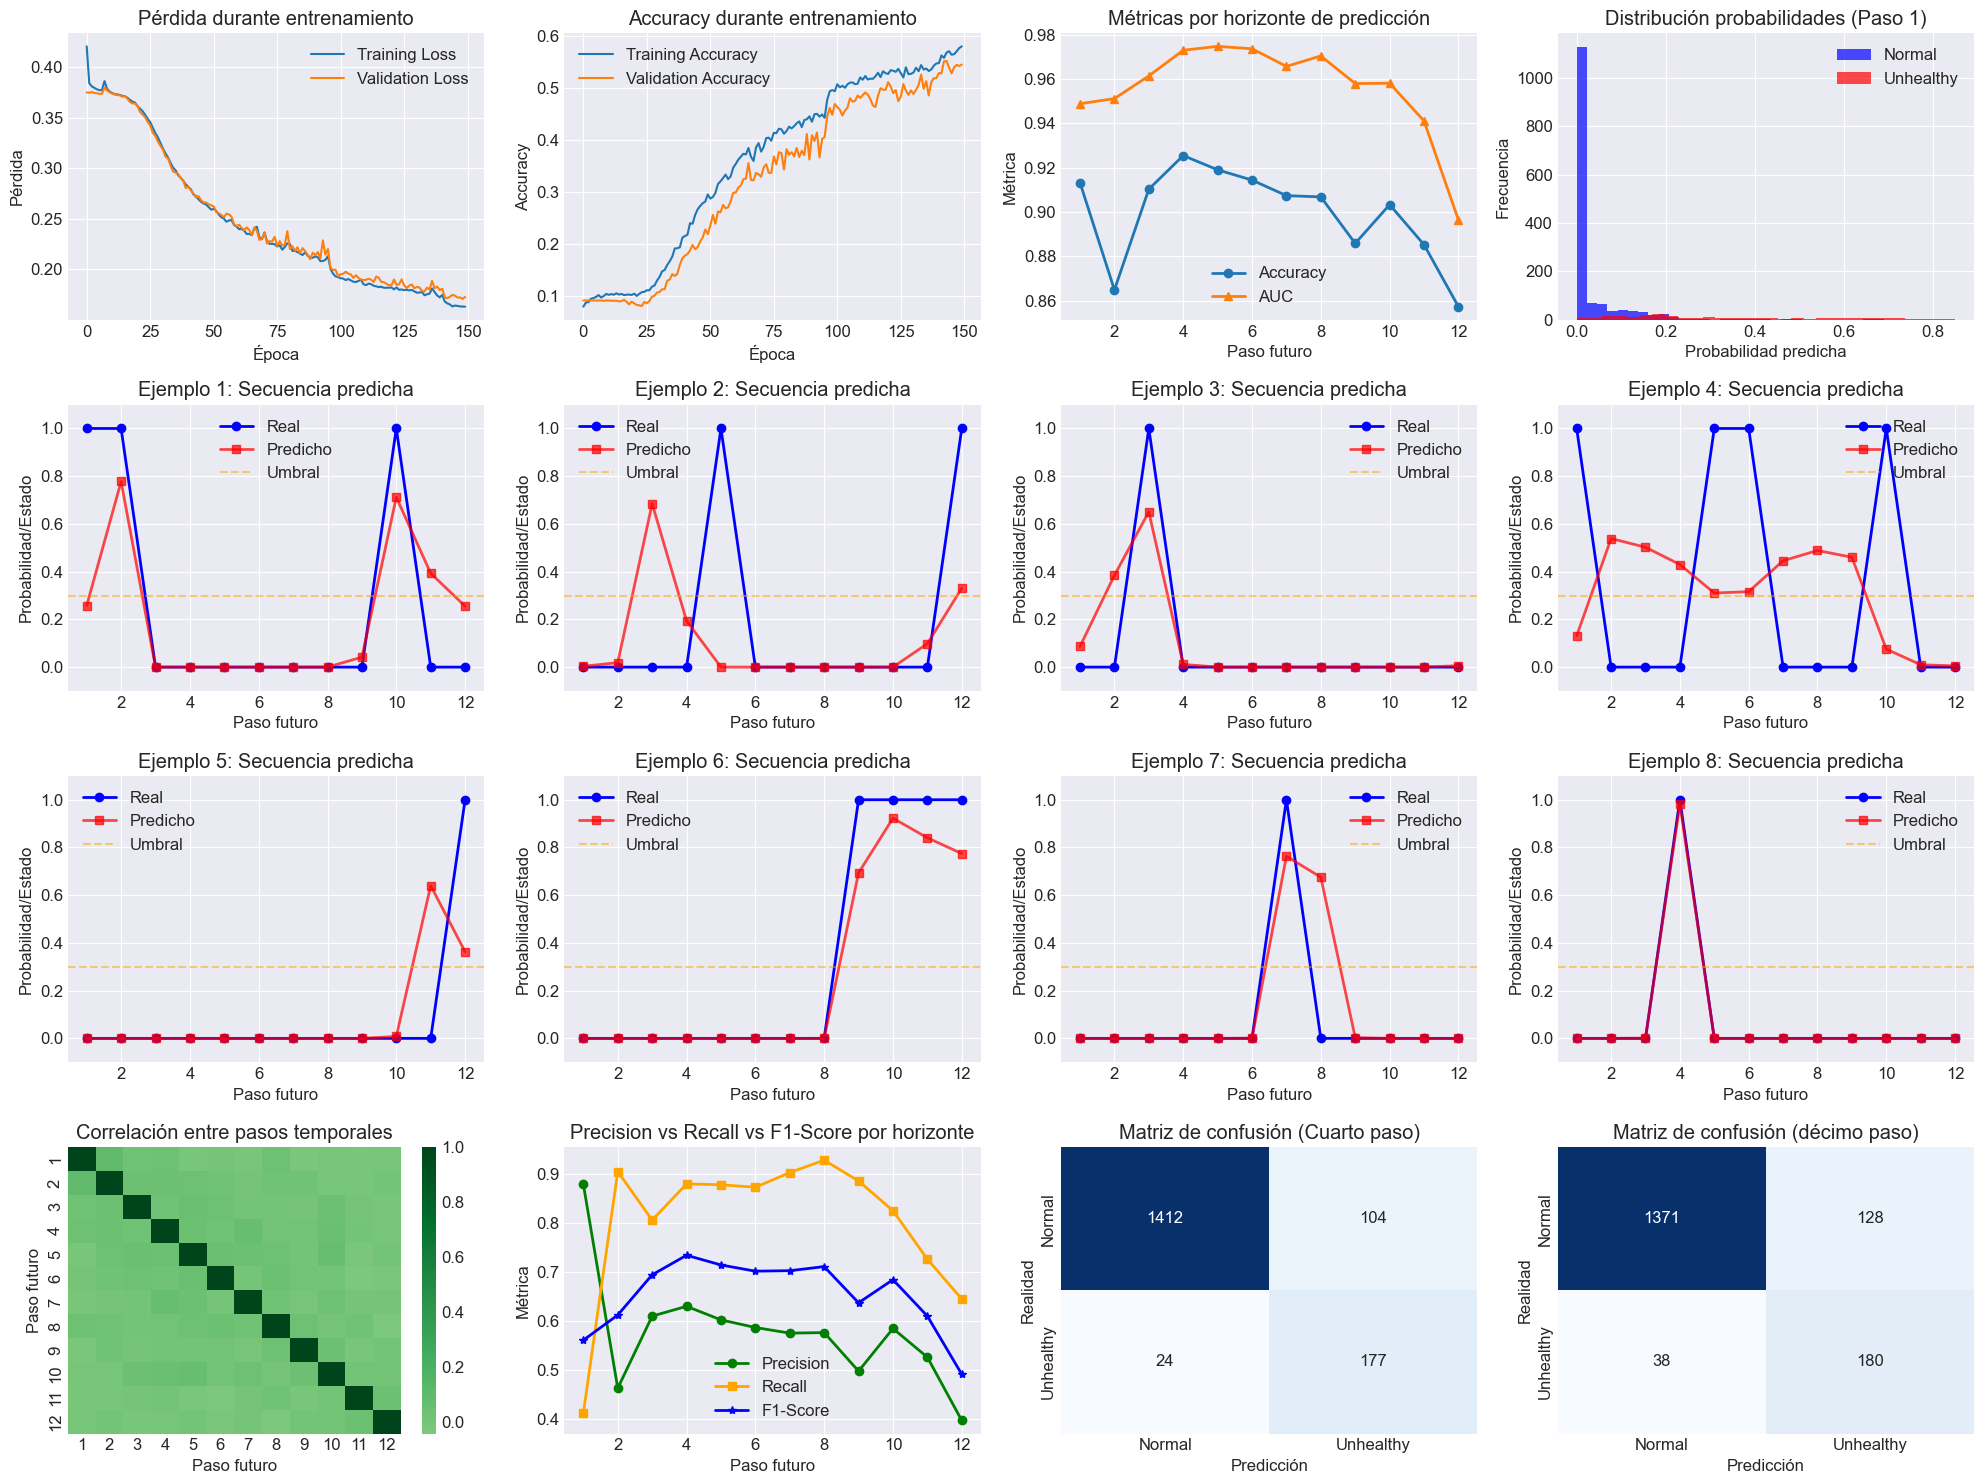

In [29]:
# Evaluar modelo y generacion de graficos
evaluate_model(data, model, X_test, y_test, y_shape, history)

# Prediccion datos nuevos

In [30]:
# Generar algunos datos nuevos para ejemplo
new_data = df_test
predictions = predict_new_sequences(model, preprocessor, new_data)
print("\n Primeras predicciones de secuencias:")
predictions.head()

if predictions is not None:
        print(f"\n Predicciones generadas: {len(predictions)} registros")
        
        # Mostrar algunas predicciones de ejemplo
        print("\n Ejemplo de predicciones de secuencia (intervalo de 15 minutos):")
        sample_base_date = predictions['Fecha_Base'].iloc[0]
        sample_predictions = predictions[predictions['Fecha_Base'] == sample_base_date]
        
        print(f"\nPredicciones desde: {sample_base_date}")
        for _, row in sample_predictions.head(12).iterrows():
            print(f"  Paso {row['Paso_Futuro']:2d}: "
                  f"{row['Fecha_Prediccion'].strftime('%H:%M')} -> "
                  f"Prob: {row['Probabilidad_Falla']:.3f} "
                  f"({'UNHEALTHY' if row['Prediccion_Binaria'] else 'NORMAL':8s})")
        
        # Estadísticas de riesgo
        high_risk = predictions[predictions['Probabilidad_Falla'] > umbral]
        print(f"\n Predicciones de alto riesgo (>{umbral *100}%): {len(high_risk)}")
        
        if len(high_risk) > 0:
            print("\n Primeros períodos de mayor riesgo (intervalo de 15 minutos):")
            risk_summary = high_risk.groupby('Fecha_Prediccion')['Probabilidad_Falla'].max().sort_values(ascending=False)
            print(risk_summary.head())

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

 Primeras predicciones de secuencias:

 Predicciones generadas: 16572 registros

 Ejemplo de predicciones de secuencia (intervalo de 15 minutos):

Predicciones desde: 2024-06-03 12:00:00
  Paso  1: 12:15 -> Prob: 0.323 (UNHEALTHY)
  Paso  2: 12:30 -> Prob: 0.755 (UNHEALTHY)
  Paso  3: 12:45 -> Prob: 0.012 (NORMAL  )
  Paso  4: 13:00 -> Prob: 0.001 (NORMAL  )
  Paso  5: 13:15 -> Prob: 0.004 (NORMAL  )
  Paso  6: 13:30 -> Prob: 0.177 (NORMAL  )
  Paso  7: 13:45 -> Prob: 0.719 (UNHEALTHY)
  Paso  8: 14:00 -> Prob: 0.047 (NORMAL  )
  Paso  9: 14:15 -> Prob: 0.000 (NORMAL  )
  Paso 10: 14:30 -> Prob: 0.000 (NORMAL  )
  Paso 11: 14:45 -> Prob: 0.000 (NORMAL  )
  Paso 12: 15:00 -> Prob: 0.000 (NORMAL  )

 Predicciones de alto riesgo (>30.0%): 2739

 Primeros períodos de mayor riesgo (intervalo de 15 minutos):
Fecha_Prediccion
2024-06-10 02:45:00    0.988835
2024-06-10 05:30:00    0.988120
2024-06-10 08:30:00    0.987895
2024-06-13 12:15:00    0.983251
2

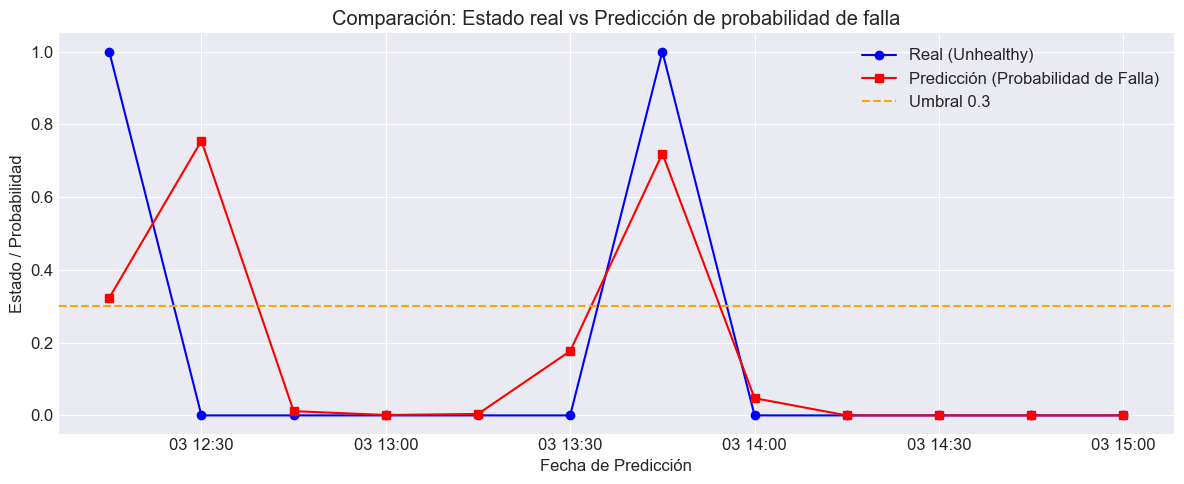

In [31]:
if predictions is not None and len(predictions) > 0:
    # Seleccionar una fecha base de ejemplo
    sample_base_date = predictions['Fecha_Base'].iloc[0]
    sample_predictions = predictions[predictions['Fecha_Base'] == sample_base_date]
    
    # Fechas de predicción
    fechas_pred = sample_predictions['Fecha_Prediccion']
    # Probabilidad predicha
    prob_pred = sample_predictions['Probabilidad_Falla']
    # Estado real
    estado_real = sample_predictions['Estado_Real']

    plt.figure(figsize=(12, 5))
    plt.plot(fechas_pred, estado_real, 'o-', label='Real (Unhealthy)', color='blue')
    plt.plot(fechas_pred, prob_pred, 's-', label='Predicción (Probabilidad de Falla)', color='red')
    plt.axhline(y=umbral, color='orange', linestyle='--', label=f'Umbral {umbral}')
    plt.xlabel('Fecha de Predicción')
    plt.ylabel('Estado / Probabilidad')
    plt.title('Comparación: Estado real vs Predicción de probabilidad de falla')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('No hay predicciones para graficar.')

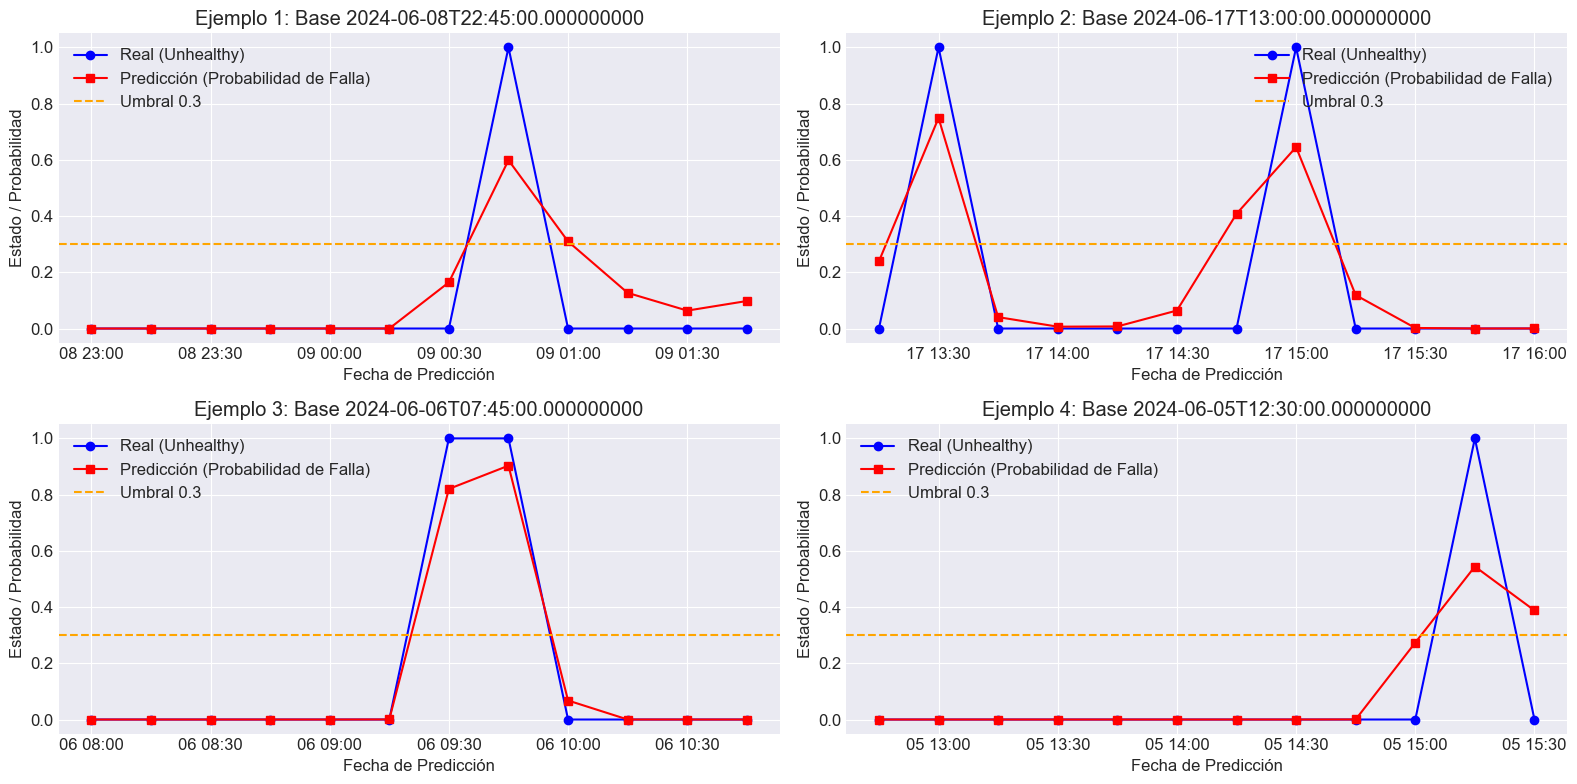

In [32]:
# Graficar 4 ejemplos de predicción vs real para diferentes fechas base de manera aleatoria
if predictions is not None and len(predictions) > 0:
    unique_bases = predictions['Fecha_Base'].unique()
    random_bases = np.random.choice(unique_bases, size=min(4, len(unique_bases)), replace=False)
    #random_bases = risk_summary.head()
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    axs = axs.flatten()
    
    for i, base_date in enumerate(random_bases):
        sample_predictions = predictions[predictions['Fecha_Base'] == base_date]
        fechas_pred = sample_predictions['Fecha_Prediccion']
        prob_pred = sample_predictions['Probabilidad_Falla']
        estado_real = sample_predictions['Estado_Real']
        
        axs[i].plot(fechas_pred, estado_real, 'o-', label='Real (Unhealthy)', color='blue')
        axs[i].plot(fechas_pred, prob_pred, 's-', label='Predicción (Probabilidad de Falla)', color='red')
        axs[i].axhline(y=umbral, color='orange', linestyle='--', label=f'Umbral {umbral}')
        axs[i].set_xlabel('Fecha de Predicción')
        axs[i].set_ylabel('Estado / Probabilidad')
        axs[i].set_title(f'Ejemplo {i+1}: Base {base_date}')
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()